# Ai Programming Evaluation

Submitted by John Fee on 3/1/2018

## Problem Statement

In this report we will utilize the provided movie rating dataset to address the following questions:
- Which are the five most popular movie genres?
- What words are characteristic of the movie summaries of said genres?
- Does the distribution of word frequencies in the movie summaries follow Zipf's law?  
    - [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) is an empirical observation that word frequencies in a corpus follow a power law probability distribution.

This notebook contains the code necessary to reproduce the analysis as the accompanying results.  See the pdf report for a concise writeup.

## Data Handling

In [1]:
# Libraries
import pandas as pd 
import json
from collections import OrderedDict

from gensim.corpora import Dictionary,MmCorpus
from gensim.models import TfidfModel
from gensim.models.phrases import Phrases,Phraser
from gensim.parsing.preprocessing import strip_non_alphanum,strip_multiple_whitespaces
from gensim.utils import SaveLoad

import spacy
nlp = spacy.load("en")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

# Set PRECOMPUTED = True if you have already run this script to avoid rerunning expensive computations
PRECOMPUTED = False

C:\Users\John\Anaconda3\envs\ai_test\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [19]:
# Loads models and processed data if required
if PRECOMPUTED:
    loader = SaveLoad()
    dictionary = loader.load("dictionary_trigram.pickle")
    bigram = loader.load("phrase_bigram.pickle")
    trigram = loader.load("phrase_trigram.pickle")
    corpus = MmCorpus("movies_bow.mm")
    tfidf = loader.load("tfidf.pickle")

In [4]:
# Import data
movies = pd.read_csv("movie_data.csv")
movies.set_index("id",inplace=True)

In [5]:
# Inspect data
movies.head()

,title,release_date,box_office_revenue,runtime,genres,summary
id,,,,,,
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,"[""Space western"", ""Horror"", ""Supernatural"", ""T...","Set in the second half of the 22nd century, th..."
1,White Of The Eye,1987,NaN,110.0,"[""Erotic thriller"", ""Psychological thriller"", ...",A series of murders of rich young women throug...
2,A Woman in Flames,1983,NaN,106.0,"[""Drama""]","Eva, an upper class housewife, becomes frustra..."
3,The Sorcerer's Apprentice,2002,NaN,86.0,"[""Adventure"", ""Fantasy"", ""World cinema"", ""Fami...","Every hundred years, the evil Morgana returns..."
4,Little city,1997-04-04,NaN,93.0,"[""Romance Film"", ""Ensemble Film"", ""Comedy-dram...","Adam, a San Francisco-based artist who works a..."


In [65]:
movies.shape

(42204, 7)

In [6]:
# Format release_date
movies["datetime"] = pd.to_datetime(movies["release_date"],errors = "coerce")

# Check to make sure NaT entries were missing (as opposed to improperly formatted)
movies_only_NaT = movies.loc[movies["datetime"].isnull(),:]
print("Number of missing release_date entries that were coerced into NaT: {}".format(len(movies_only_NaT["release_date"].isnull())))
print("Number of missing release date entries:  {}".format(len(movies_only_NaT["release_date"])))

Number of missing release_date entries that were coerced into NaT: 2619
Number of missing release date entries:  2619


In [7]:
# Is id an irrelevant field?
title_unique = len(movies["title"].unique())
title_total = len(movies["title"])
print("Number of unique movie titles: {}".format(title_unique))
print("Number of total movie titles: {}".format(title_total))

Number of unique movie titles: 39914
Number of total movie titles: 42204


In [8]:
# Inspect duplicates
duplicated_index = movies["title"].duplicated(keep = False)
movies.loc[duplicated_index,:].sort_values("title")[0:10] # Print first 10 rows of duplicates next to each other

,title,release_date,box_office_revenue,runtime,genres,summary,datetime
id,,,,,,,
6303,100% Love,2011-04,NaN,140.0,"[""Romantic comedy""]",Balu Mahendra is always the number one studen...,2011-04-01
35723,100% Love,2012-01-20,NaN,NaN,"[""Romance Film"", ""Comedy film""]",Rahul ([[Jeet is from a middle-class family. ...,2012-01-20
14142,12,2007,4000000.0,160.0,"[""Courtroom Drama"", ""Crime Fiction"", ""War film...",The jury decides whether a young Chechen boy i...,2007-01-01
9250,12,2003-06-27,NaN,124.0,"[""Comedy film"", ""Indie"", ""Musical""]",The film is a postmodern spoof that tells the ...,2003-06-27
17455,12 Angry Men,1957-04-10,1000000.0,96.0,"[""Drama""]",The story begins in a courtroom where an 18-ye...,1957-04-10
11078,12 Angry Men,1997-08-17,NaN,117.0,"[""Drama""]",After the final closing arguments have been pr...,1997-08-17
720,12:01 PM,1990,NaN,25.0,"[""Science Fiction"", ""Psychological thriller"", ...","Kurtwood Smith plays Myron Castleman,<ref name...",1990-01-01
8227,12:01 PM,1993-07-05,NaN,94.0,"[""Romance Film"", ""Television movie"", ""Science ...",Expanding on the original's premise of a one h...,1993-07-05
24822,180,2011-06-10,NaN,NaN,"[""Romance Film"", ""Drama""]",The movie revolves around Ajay who comes to C...,2011-06-10


Note that just from inspection of just a few entries we can see that duplicated titles do not have consistent values for any of the other variables.  We extrapolate from the summaries here and assume they are unique movies.

In [9]:
# Fill movies box office revenue with zeroes
movies["box_office_revenue"] = movies["box_office_revenue"].fillna(0)

In [10]:
# Create genres dataframe with properly formatted binary columns
# First add all of the columns, then fills in the appropriate entries
# This makes the dataframe sparse

# Get genre names
genre_names = set()
for index,item in enumerate(movies["genres"]):
    genres_in_movie = json.loads(item) # Converts string representation of list to list
    for genre in genres_in_movie:
        genre_names.add(genre)
        
# Create new dataframe    
genre_df = pd.DataFrame({"id": movies.index})
genre_df.set_index("id",inplace=True)
for genre in genre_names:
    genre_df[genre] = 0*len(movies)    
    
# Fill in genre columns
for index,item in enumerate(movies["genres"]):
    genres = json.loads(item)
    for genre in genres:
        genre_df.at[index,genre] = 1    

In [11]:
# Inspect missingness of box office revenue
fraction_of_missing_data = (movies["box_office_revenue"]== 0).sum()/len(movies)
print("{}% of movies have box_office_revenue missing".format(round(100*fraction_of_missing_data)))

82.0% of movies have box_office_revenue missing


## Question 1 - Popular Movie Genres

We should be clear about the assumptions we are making:
- We define popularity of a movie genre as the number of unique moviegoers who purchase tickets for a movie belonging to that genre.
    - This is a plausible way to define the popularity of a movie with *viewers* but the question could be interpreted otherwise (e.g. how popular is a genre with producers?).
- Since granular ticket data is not available, we use aggregated box office revenue as a proxy variable for popularity.
- We assume that box office revenue is a monotonic function of popularity with the caveats that
    - We don't know if box office revenue has been inflation adjusted
    - If there is any heterogeneity in ticket price this will skew our popularity estimate to the preferences of more expensive movie ticket buyers
- Most revenue entries are missing and for the purposes of this evaluation we exclude them from the ranking.

Therefore, to identify the top five movie genres we add the revenue of each movie to the genre it belongs to and select the top five for further consideration.

In [55]:
# Get top 5 genres by revenue
def top_n_genres_by_revenue(n = 5):
    df = genre_df.multiply(movies["box_office_revenue"],axis = "index")
    genre_revenue = df.sum().sort_values(ascending = False)
    
    results_df = pd.DataFrame({"Genre":genre_revenue.index[0:n],"Revenue (trillions)": round(genre_revenue[0:n]*10e-12,2)})
    return results_df

# Results
results = top_n_genres_by_revenue()
top_5_genres = results["Genre"]
results

,Genre,Revenue (trillions)
Drama,Drama,1.68
Comedy,Comedy,1.58
Action,Action,1.54
Thriller,Thriller,1.37
Adventure,Adventure,1.33


In [56]:
# Save results for report
with open('latex_tables.txt', 'a') as results_file:
    results_file.write(results.to_latex(index = False))
    results_file.write("\n")

I double checked the calculation because this is a staggering amount of money.

## Question 2 - Characteristic Words

Now that we have identified the most popular genres, we turn to the task of extracting characteristic words for the relevant genres.  We can measure this by calculating each word's Term Frequency - Inverse Document Frequency (TF-IDF).  A word's TF-IDF score for a given document is proportional to how frequently the word appears in the document, and inversely proportional to how frequently it appears in the entire body of texts (or more often, the logarithm of said quantity).  

In this case, since we are interested in a word's importance for a genre, the "document" of interest is the body of summaries associated with the given genre.  While this is a very simple approach to identifying word importance (which disregards word dependency within a document), it works well empirically and is simple to implement.

To improve upon the ability of TF-IDF to identify characteristic words, we apply the following transformations to the text summaries:
- Remove non-alphanumeric characters (punctuation can spuriously differentiate words)
- Remove both very common and very uncommon words (which are not the object of interest for this analysis)
- Use SpaCy's models to break text up into tokens and lemmatize the tokens
- Join together words which frequently co-occur into single units (phrases)
    - Phrase detection is in the spirit of the assignment, if not the letter


In [13]:
# Create simple text cleaner
def clean_text(doc):
    output_text = strip_non_alphanum(doc) # Remove punctuation
    output_text = strip_multiple_whitespaces(output_text)
    return output_text

# Create data generator
class data_generator(object):
    def __init__(self,batch_size = 1000,n_threads = -1):
        self.batch_size = batch_size
        self.n_threads = n_threads
    
    def __iter__(self):
        data_gen = (clean_text(doc) for doc in movies["summary"])
        for doc in nlp.pipe(data_gen,batch_size = self.batch_size,n_threads = self.n_threads):
            output_doc = []
            for sentence in doc.sents:
                for token in sentence:
                    output_doc.append(token.lemma_)
            yield output_doc   

In [15]:
# Identify phrases up to three tokens in length by co-occurrence frequency and join them with underscore 
# Phrases trains the model used to identify phrases, while Phraser is used to apply the trained model and link words with _
if not PRECOMPUTED:
    phrases = Phrases(data_generator())
    bigram = Phraser(phrases)
    bigram.save("phrase_bigram.pickle")
    
    phrases = Phrases(bigram[data_generator()])
    trigram = Phraser(phrases)
    trigram.save("phrase_trigram.pickle")

In [16]:
# Transform corpus into bag of words representation and saves it
if not PRECOMPUTED:
    dictionary = Dictionary(trigram[data_generator()])
    dictionary.filter_extremes(no_below = 10,no_above=0.5)
    dictionary.save("dictionary_trigram.pickle")    
    corpus = (dictionary.doc2bow(trigram[doc]) for doc in data_generator())
    MmCorpus.serialize('movies_bow.mm', corpus)
    

In [21]:
# Streams corpus from disk and performs TF-IDF transformation for each genre
# Appends movies belong to the same genre together so they are treated as a single document during TF-IDF transformation
def get_genres(index):
    genre_index = genre_df.iloc[index,:].nonzero()
    genres = genre_df.columns[genre_index]
    return genres

class genre_generator(object):
    def __init__(self,genre_names = genre_df.columns):
        self.genre_names = genre_names
        
    def __iter__(self):
        corpus = MmCorpus("movies_bow.mm")
        word_ids = [word for word in dictionary.iterkeys()]
        n_words = len(word_ids)
        
        for genre in self.genre_names:
            # Initialize empty frequency dataframe
            genre_big_df = pd.Series(data = [0 for i in range(n_words)],index = word_ids)
            for index,doc in enumerate(corpus):
                doc_genres = get_genres(index)
                if genre in doc_genres:
                    # Update frequency dataframe with new word counts
                    for tup in doc:
                        word_id = tup[0]
                        word_frequency = tup[1]
                        genre_big_df.at[word_id] += word_frequency
            # Remove words from dataframe that have frequency 0 or gensim will count them as present
            genre_big_df = genre_big_df[genre_big_df != 0]
            yield [item for item in genre_big_df.iteritems()]

# Save corpus by genre and train TF-IDF transformer
if not PRECOMPUTED:
    tfidf = TfidfModel(genre_generator())
    tfidf.save("tfidf.pickle")

In [62]:
# Make reverse dictionary mapping to get words from BoW representation
dictionary.id2token = dict((token,token_id) for token_id,token in dictionary.token2id.items()) # Get id to token mapping
dictionary.save(("dictionary_trigram.pickle"))

# Get top 10 characteristic results for each genre
def tfidf_top_n_characteristic_words(genre_names = top_5_genres,n = 10):
    results_df = pd.DataFrame({"Word":[],"tfidf_score":[],"Genre":[]})
    for genre_index,genre_big_doc in enumerate(genre_generator(genre_names)):
        genre_big_doc_tfidf = tfidf[genre_big_doc]
        genre_big_doc_tfidf = sorted(genre_big_doc_tfidf,key = lambda x:x[1],reverse=True)
        
        genre = genre_names[genre_index]
        words = [dictionary.id2token[genre_big_doc_tfidf[index][0]] for index in range(n)]
        tfidf_scores = [genre_big_doc_tfidf[index][1] for index in range(n)]
        single_genre_df = pd.DataFrame({"Word": words,"tfidf_score": [round(score,4) for score in tfidf_scores],"Genre": genre})
        results_df = results_df.append(single_genre_df)
    return results_df

results = tfidf_top_n_characteristic_words(n = 10)
results

,Genre,Word,tfidf_score
0,Drama,father,0.0846
1,Drama,marry,0.0722
2,Drama,love,0.0713
3,Drama,mother,0.0693
4,Drama,family,0.0692
5,Drama,tell,0.0690
6,Drama,get,0.0689
7,Drama,child,0.0657
8,Drama,son,0.0654
9,Drama,police,0.0620


In [64]:
# Save results for report
with open('latex_tables.txt', 'a') as results_file:
    for genre in top_5_genres:
        results_file.write(results.loc[results["Genre"] == genre,["Word","tfidf_score"]].to_latex(index = False))
        results_file.write("\n")

Most of the keyword results are verbs that are commonly associated with the genre, with nouns and proper nouns coming in second and third.  

## Question 3 - Zipf's Law

In [66]:
# Class to count word frequencies
# Gensim only counts document frequency
class word_frequency(object):
    def __init__(self,doc = None,ascending = True):
        self.frequencies = {}
        self.ascending = ascending
        if doc:
            self.add_doc(doc)
            self.sort()
        
    def __iter__(self):
        for item in self.frequencies:
            yield item    
            
    def add_doc(self,doc):
        for word in doc:
            if word in self.frequencies:
                self.frequencies[word] +=1
            else:
                self.frequencies[word] = 1
            
    def sort(self):
        self.frequencies = OrderedDict(sorted(self.frequencies.items(),key = lambda x:x[1],reverse=self.ascending))

frequency_dic = word_frequency()
for doc in data_generator():
    frequency_dic.add_doc(doc)
frequency_dic.sort()
frequency_df = pd.Series(frequency_dic.frequencies)

-PRON-    979791
the       823537
to        481007
and       456323
be        383181
a         376696
of        261152
in        222241
s         157033
with      139137
that      139038
have      107266
for        94932
by         92473
as         88780
on         83465
but        71821
who        71296
at         63858
from       60655
dtype: int64

In [71]:
N = len(frequency_df)
[(n+1)**-1 for n in range(N)]

[1.0,
 0.5,
 0.3333333333333333,
 0.25,
 0.2,
 0.16666666666666666,
 0.14285714285714285,
 0.125,
 0.1111111111111111,
 0.1,
 0.09090909090909091,
 0.08333333333333333,
 0.07692307692307693,
 0.07142857142857142,
 0.06666666666666667,
 0.0625,
 0.058823529411764705,
 0.05555555555555555,
 0.05263157894736842,
 0.05,
 0.047619047619047616,
 0.045454545454545456,
 0.043478260869565216,
 0.041666666666666664,
 0.04,
 0.038461538461538464,
 0.037037037037037035,
 0.03571428571428571,
 0.034482758620689655,
 0.03333333333333333,
 0.03225806451612903,
 0.03125,
 0.030303030303030304,
 0.029411764705882353,
 0.02857142857142857,
 0.027777777777777776,
 0.02702702702702703,
 0.02631578947368421,
 0.02564102564102564,
 0.025,
 0.024390243902439025,
 0.023809523809523808,
 0.023255813953488372,
 0.022727272727272728,
 0.022222222222222223,
 0.021739130434782608,
 0.02127659574468085,
 0.020833333333333332,
 0.02040816326530612,
 0.02,
 0.0196078431372549,
 0.019230769230769232,
 0.01886792452830

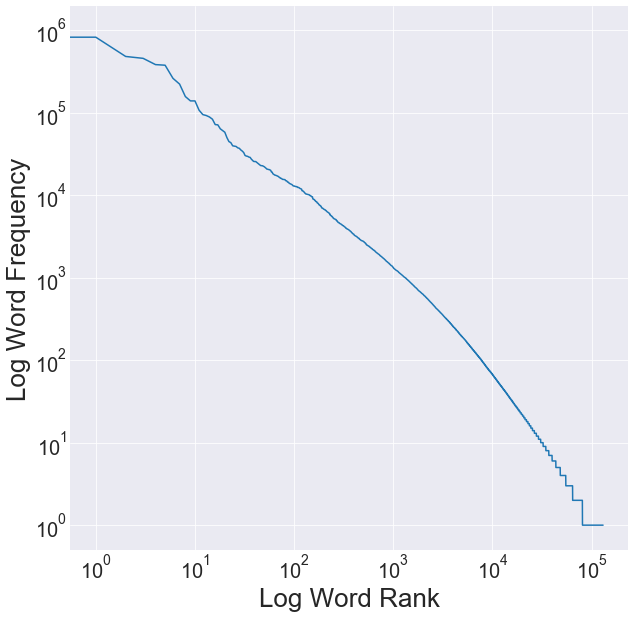

In [86]:
# Inspect graphically
# Data for graph
x,y = [i for i in range(len(frequency_df))],frequency_df

# Graph Specification
figure,(axis1) = plt.subplots(1,1,figsize = (10,10))

axis1.plot(x,y)
axis1.set_yscale('log')
axis1.set_xscale("log")
axis1.set_xlabel("Log Word Rank",fontsize = 26)
axis1.set_ylabel("Log Word Frequency",fontsize = 26)
axis1.tick_params(labelsize=20)
plt.savefig("Word_Frequency_Plot.PNG")
plt.show()

In [ ]:
sns.regplot()